### References
- https://jovian.ai/aakashns/03-logistic-regression

### Imports

In [1]:
import pathlib
import torch
import torchvision
from torchvision.datasets import MNIST
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
# sns.set()
import numpy as np
import torchvision.transforms as transforms

### IO

- 入出力ファイルの場所は先頭に記述する方が、後からわかりやすい。

In [26]:
INPUT_DOWNLOAD_PATH = pathlib.Path('./data').joinpath('03_mnist', 'input')

pathlib.Path('./data').joinpath('03_mnist', 'output').mkdir(parents=True, exist_ok=True)
OUTPUT_MODEL_FILE = pathlib.Path('./data').joinpath('03_mnist', 'output', 'mnist-logistic.pth')

### Load dataset

In [3]:
ds = MNIST(root=INPUT_DOWNLOAD_PATH, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/03_mnist/input/MNIST/raw/train-images-idx3-ubyte.gz to data/03_mnist/input/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/03_mnist/input/MNIST/raw/train-labels-idx1-ubyte.gz to data/03_mnist/input/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/03_mnist/input/MNIST/raw/t10k-images-idx3-ubyte.gz to data/03_mnist/input/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/03_mnist/input/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/03_mnist/input/MNIST/raw



/usr/local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


- train, testは既に分かれている状態のようだ。
  - 実務では、MNISTというクラスと同じようなものをデータ毎に作成する必要がある。

In [4]:
train_ds = MNIST(root=INPUT_DOWNLOAD_PATH, train=True)
test_ds = MNIST(root=INPUT_DOWNLOAD_PATH, train=False)
display(f"train_num: {len(train_ds)}, test_num: {len(test_ds)}")

'train_num: 60000, test_num: 10000'

- 1サンプルのデータは、tupleとなっており、画像データとラベルの組である。
  - PIL.Imageは画像を扱うデータタイプ。
  - PIL自体は、更新が2009年で止まっているライブラリだが、<br>
  歴史的経緯からデータ型としては残っているようだ。
  - PILは今は、Pillowにフォークしている。

In [5]:
display(f"type: {type(train_ds[0])}")
display(f"value: {train_ds[0]}")
display(f"type: {type(test_ds[0])}")
display(f"value: {test_ds[0]}")

"type: <class 'tuple'>"

'value: (<PIL.Image.Image image mode=L size=28x28 at 0x7F4175C6B610>, 5)'

"type: <class 'tuple'>"

'value: (<PIL.Image.Image image mode=L size=28x28 at 0x7F4175C6B610>, 7)'

- PIL.Image.Imageは、numpyと相互変換できる。
  - dtypeはuint8になっているようだ。

In [6]:
arr = np.asarray(train_ds[0][0])
display(f"type: {type(arr)}, dtype: {arr.dtype}, shape: {arr.shape}")

img = Image.fromarray(arr)
display(img)

"type: <class 'numpy.ndarray'>, dtype: uint8, shape: (28, 28)"

- 画像を見るとこんな感じ。

'label: 5'

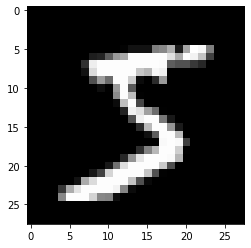

In [7]:
image, label = train_ds[0]
display(f"label: {label}")
plt.imshow(image, cmap='gray')

- 実際には、numpy変換にしなくとも、MNISTというモジュールで良い感じにtensorにしてくれる。
  - この良い感じにする部分は、自分で作れる必要があるんだろう。
- 形式がtensorになっているだけではなく、0～1に勝手に正規化してる部分は少し癖つよい。

In [8]:
train_ds = MNIST(root=INPUT_DOWNLOAD_PATH, 
                train=True,
                transform=transforms.ToTensor())

test_ds = MNIST(root=INPUT_DOWNLOAD_PATH, 
                train=False,
                transform=transforms.ToTensor())

image, label = train_ds[0]

display(f"type: {type(image)}, dtype: {image.dtype}, shape: {image.shape}")
display(f"type: {type(label)}")

"type: <class 'torch.Tensor'>, dtype: torch.float32, shape: torch.Size([1, 28, 28])"

"type: <class 'int'>"

### Train Valid分割

- Deep Learningモデルはパラメータが膨大なことが多いため、過学習状態になる可能性が高い。
- 過学習にならないようにするため、Validationは必須である。
- そのため、データセットは通常、３つに分割される。
  - Train ... モデルのパラメータ更新に使う学習データ
  - Valid ... モデルが過学習になっていないか、学習中に確認するためのデータ
  - Test ... 最後の評価にしか使わないデータ
- 学習データとはTrain+Validを意味する場合もあれば、Trainのみを意味する場合もある。
- 余談
  - Testは未使用の評価にしか使わない位置づけだが、実際はTestの性能を見ながら、色々試すため、<br>
    完全な未使用状態は保てない（１回使ったら、厳しい目では使用済みデータとなる。）
  - そういう意味では、完全なTestデータは存在しないと認識しておいた方が良い。

In [9]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(train_ds, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

### DataLoader

In [10]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [11]:
# DataLoaderテスト
for images, labels in train_loader:
    display(labels.shape)
    display(images.shape)
    break

torch.Size([128])

torch.Size([128, 1, 28, 28])

### Model

- 線形分類モデルを作成したいですが、nn.Linearの入力と合わないため独自モデル定義の練習台にしている。
- input_shapeやnum_classesは外から与えられるべきなので、コンストラクタの引数にした。

In [12]:
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        
        input_size = 1
        for i in input_shape[1:]:
            input_size = input_size * i
        self.linear = nn.Linear(input_size, num_classes)
        
        self.input_size = input_size
        
    def forward(self, xb):
        xb = xb.reshape(-1, self.input_size)
        out = self.linear(xb)
        return out
    
model = CustomModel(images.shape, 10)

for p in model.parameters():
    display(f"dtype: {p.dtype}, shape: {p.shape}")
    display(p)

'dtype: torch.float32, shape: torch.Size([10, 784])'

Parameter containing:
tensor([[ 0.0219,  0.0259, -0.0328,  ...,  0.0002,  0.0043, -0.0286],
        [ 0.0136, -0.0014,  0.0157,  ..., -0.0265, -0.0170, -0.0042],
        [-0.0223,  0.0041, -0.0296,  ...,  0.0251,  0.0235,  0.0285],
        ...,
        [-0.0202, -0.0075, -0.0152,  ..., -0.0135, -0.0003,  0.0325],
        [-0.0126,  0.0172, -0.0016,  ..., -0.0209, -0.0109, -0.0210],
        [ 0.0031,  0.0345,  0.0204,  ...,  0.0288,  0.0205, -0.0262]],
       requires_grad=True)

'dtype: torch.float32, shape: torch.Size([10])'

Parameter containing:
tensor([ 0.0091, -0.0003,  0.0120, -0.0277,  0.0072, -0.0092, -0.0202, -0.0173,
        -0.0343,  0.0325], requires_grad=True)

- 推論のテスト
  - 出力はバッチサイズ128 x クラス数10となる。

In [13]:
outputs = model(images)
outputs
display(f"dtype: {outputs.dtype}, shape: {outputs.shape}")
display(outputs)

'dtype: torch.float32, shape: torch.Size([128, 10])'

tensor([[-0.2198, -0.3558, -0.1824,  ...,  0.0079,  0.0074,  0.1941],
        [-0.0332, -0.2391, -0.0804,  ..., -0.0520,  0.1393, -0.0013],
        [-0.6905,  0.0435,  0.1895,  ..., -0.0985,  0.0189, -0.1476],
        ...,
        [-0.2222, -0.1789, -0.2740,  ..., -0.1612, -0.1849,  0.0231],
        [-0.1623, -0.2849, -0.0308,  ...,  0.3096, -0.0524,  0.1756],
        [-0.0024,  0.0373, -0.2624,  ..., -0.2701, -0.1891,  0.1391]],
       grad_fn=<AddmmBackward>)

- モデルは線形変換のみであるため、出力はまだ、回帰と同じ連続値。
- それを各クラス10個毎の確率値にsoftmaxで変換するため、softmaxを使う。
  - softmaxは10個中最大の値をとるものが1に近づき、それ以外が0に近づき、合計が1となるような変換。

In [14]:
import torch.nn.functional as F

probs = F.softmax(outputs, dim=1)
display(f"dtype: {probs.dtype}, shape: {probs.shape}")
display(probs)

'dtype: torch.float32, shape: torch.Size([128, 10])'

tensor([[0.0867, 0.0757, 0.0900,  ..., 0.1089, 0.1088, 0.1312],
        [0.1037, 0.0844, 0.0989,  ..., 0.1017, 0.1232, 0.1070],
        [0.0534, 0.1112, 0.1287,  ..., 0.0965, 0.1085, 0.0919],
        ...,
        [0.0923, 0.0964, 0.0876,  ..., 0.0981, 0.0958, 0.1179],
        [0.0868, 0.0768, 0.0990,  ..., 0.1392, 0.0969, 0.1217],
        [0.1062, 0.1105, 0.0819,  ..., 0.0812, 0.0881, 0.1223]],
       grad_fn=<SoftmaxBackward>)

- 1sampleだけ例を見てみるが、まだ学習していないため、どの値もそんなに変わらない値

In [15]:
display(probs[0])

tensor([0.0867, 0.0757, 0.0900, 0.0887, 0.1294, 0.1004, 0.0801, 0.1089, 0.1088,
        0.1312], grad_fn=<SelectBackward>)

- さらに最大値をとって、どのクラスにするかを決定する。
  - maxは単純に、最大値と最大値だったindexを計算する関数。
  - 最大値は、値の確からしさ(スコアと呼んだりする)、indexは分類結果そのものになる。

In [16]:
max_probs, preds = torch.max(probs, dim=1)
display(f"dtype: {max_probs.dtype}, shape: {max_probs.shape}")
display(max_probs)

display(f"dtype: {preds.dtype}, shape: {preds.shape}")
display(preds)

'dtype: torch.float32, shape: torch.Size([128])'

tensor([0.1312, 0.1232, 0.1346, 0.1229, 0.1171, 0.1450, 0.1160, 0.1331, 0.1365,
        0.1168, 0.1322, 0.1292, 0.1391, 0.1445, 0.1126, 0.1194, 0.1285, 0.1329,
        0.1175, 0.1357, 0.1342, 0.1410, 0.1646, 0.1149, 0.1258, 0.1349, 0.1465,
        0.1388, 0.1227, 0.1683, 0.1311, 0.1333, 0.1463, 0.1319, 0.1136, 0.1227,
        0.1147, 0.1208, 0.1290, 0.1215, 0.1431, 0.1196, 0.1276, 0.1241, 0.1381,
        0.1177, 0.1482, 0.1640, 0.1261, 0.1170, 0.1232, 0.1291, 0.1210, 0.1350,
        0.1268, 0.1394, 0.1496, 0.1187, 0.1285, 0.1368, 0.1285, 0.1233, 0.1169,
        0.1253, 0.1180, 0.1186, 0.1401, 0.1269, 0.1384, 0.1301, 0.1212, 0.1329,
        0.1172, 0.1520, 0.1401, 0.1306, 0.1544, 0.1370, 0.1316, 0.1393, 0.1225,
        0.1186, 0.1279, 0.1202, 0.1256, 0.1268, 0.1316, 0.1214, 0.1193, 0.1248,
        0.1220, 0.1307, 0.1227, 0.1311, 0.1374, 0.1177, 0.1330, 0.1162, 0.1126,
        0.1128, 0.1330, 0.1304, 0.1344, 0.1276, 0.1352, 0.1359, 0.1308, 0.1154,
        0.1565, 0.1310, 0.1182, 0.1510, 

'dtype: torch.int64, shape: torch.Size([128])'

tensor([9, 8, 6, 4, 3, 8, 5, 7, 7, 2, 4, 7, 7, 7, 2, 8, 9, 8, 7, 9, 6, 9, 7, 9,
        9, 9, 7, 7, 9, 7, 7, 8, 4, 4, 7, 7, 5, 9, 8, 6, 4, 4, 8, 7, 6, 7, 7, 7,
        6, 3, 2, 6, 9, 6, 9, 2, 7, 4, 6, 4, 6, 7, 9, 7, 2, 2, 7, 8, 9, 7, 8, 7,
        8, 7, 1, 8, 7, 6, 7, 6, 4, 6, 9, 5, 7, 8, 9, 8, 4, 4, 3, 4, 4, 8, 4, 3,
        7, 9, 7, 4, 4, 4, 7, 6, 4, 7, 8, 9, 7, 6, 9, 9, 9, 7, 8, 8, 7, 8, 6, 7,
        8, 2, 4, 3, 7, 5, 7, 9])

### lossに関する議論
  - 分類問題の評価には、正解率などを求めます。
  - しかしこれをlossとして使用するのは一般的ではありません。理由は以下です。
    - 正解率は微分可能な関数ではない（不連続値をとる）。
    - 離散的な値のため、改善のために正確なフィードバックを得られない。
  - 一般的には、クロスエントロピーを使います。
    - クスエントロピーは、2つの確率分布が同じであるほど、小さくなる関数です。
  - クロスエントロピーは、pytorchに関数として用意されています。
  - この関数は、log_softmaxとnll_lossが入っているので、softmaxしなくてよくなるみたい。

In [17]:
loss_fn = F.cross_entropy
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3046, grad_fn=<NllLossBackward>)


### Fit
- training_stepなどがmodelの中に入るのは、個人的には苦手な実装

In [18]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):

    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for images, labels in train_loader:
            
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        train_loss, train_acc = evaluate(model, train_loader)
        
        # Validation phase
        val_loss, val_acc = evaluate(model, val_loader)
        
        print(f"Epoch: {epoch}, ", end="")
        print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}, ", end="")
        print(f"val_loss: {val_loss:.3f}, val_acc: {val_acc:.3f}")
        
        history.append({"train_loss": train_loss, 
                        "train_acc": train_acc, 
                        "val_loss": val_loss, 
                        "val_acc": val_acc,
                       })

    return history

def evaluate(model, val_loader):
    
    loss_list = []
    acc_list = []
    
    for images, labels in val_loader:
        
        outputs = model(images)
        
        loss = F.cross_entropy(outputs, labels)
        loss_list.append(loss)
        
        acc = accuracy(outputs, labels)
        acc_list.append(acc)
        
    loss_mean = torch.stack(loss_list).mean().item()
    acc_mean = torch.stack(acc_list).mean().item()
    
    return loss_mean, acc_mean

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

- evaluateができるかチェック

In [19]:
model = CustomModel(images.shape, 10)
evaluate(model, val_loader)

(2.2873551845550537, 0.09088212251663208)

- 学習は、30epochくらい一気にやる。

In [20]:
history = fit(30, 0.001, model, train_loader, val_loader)

Epoch: 0, train_loss: 1.929, train_acc: 0.643, val_loss: 1.927, val_acc: 0.641
Epoch: 1, train_loss: 1.665, train_acc: 0.729, val_loss: 1.661, val_acc: 0.730
Epoch: 2, train_loss: 1.468, train_acc: 0.762, val_loss: 1.464, val_acc: 0.769
Epoch: 3, train_loss: 1.320, train_acc: 0.783, val_loss: 1.315, val_acc: 0.789
Epoch: 4, train_loss: 1.205, train_acc: 0.796, val_loss: 1.200, val_acc: 0.802
Epoch: 5, train_loss: 1.115, train_acc: 0.805, val_loss: 1.109, val_acc: 0.811
Epoch: 6, train_loss: 1.043, train_acc: 0.812, val_loss: 1.037, val_acc: 0.819
Epoch: 7, train_loss: 0.983, train_acc: 0.818, val_loss: 0.977, val_acc: 0.825
Epoch: 8, train_loss: 0.934, train_acc: 0.823, val_loss: 0.927, val_acc: 0.830
Epoch: 9, train_loss: 0.892, train_acc: 0.827, val_loss: 0.885, val_acc: 0.834
Epoch: 10, train_loss: 0.856, train_acc: 0.831, val_loss: 0.849, val_acc: 0.838
Epoch: 11, train_loss: 0.825, train_acc: 0.834, val_loss: 0.818, val_acc: 0.840
Epoch: 12, train_loss: 0.798, train_acc: 0.837, va

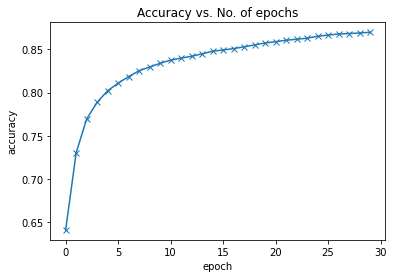

In [21]:
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

- 精度が悪い理由がいくつか書かれているが、他にもいろいろあると思われる。
  - 言及されている通り、learning rateが大きすぎる。
    - そもそも固定ではない方法のほうが良い。
  - そもそも全結合では、位置情報が使われないことになるため、画像には向いてない。
    - 例えば、隣接する画素が、隣接していることが、直接的に使われていない。
    - これは、Convを使う大きな理由である。
  - 入力の変動に頑健ではない。
    - ここはBachNormalizationを使うのが標準的だ。
  - 言及されている通り単純に層が浅いので、モデルが単純すぎる。

### 推論テスト

Label: 7 , Predicted: 7


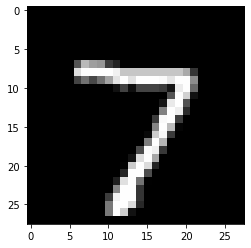

In [22]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

img, label = test_ds[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [23]:
test_loader = DataLoader(test_ds, batch_size=256)
test_loss, test_acc = evaluate(model, test_loader)
display(test_loss, test_acc)

0.5516924858093262

0.871386706829071

### モデルの保存

- OrderdDictで保存される。(順番が保証される辞書型)

In [24]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0209,  0.0305,  0.0310,  ...,  0.0299, -0.0032,  0.0341],
                      [-0.0086, -0.0340, -0.0288,  ...,  0.0074, -0.0194,  0.0109],
                      [ 0.0091, -0.0291,  0.0321,  ...,  0.0038, -0.0173,  0.0219],
                      ...,
                      [-0.0261,  0.0298,  0.0119,  ..., -0.0328, -0.0123,  0.0261],
                      [ 0.0275,  0.0201,  0.0211,  ..., -0.0247, -0.0332, -0.0274],
                      [-0.0099,  0.0290, -0.0285,  ..., -0.0001,  0.0057, -0.0238]])),
             ('linear.bias',
              tensor([-0.0651,  0.1007, -0.0422, -0.0246,  0.0562,  0.0986,  0.0152,  0.0374,
                      -0.0998,  0.0116]))])

- 保存

In [27]:
torch.save(model.state_dict(), OUTPUT_MODEL_FILE)

### モデル読み込みと推論

In [32]:
model2 = CustomModel(images.shape, 10)
display(evaluate(model2, test_loader))

model2.load_state_dict(torch.load(OUTPUT_MODEL_FILE))
display(evaluate(model2, test_loader))

(2.2983899116516113, 0.142578125)

(0.5516924858093262, 0.871386706829071)

In [33]:
import jovian
jovian.commit(project='pytorch-tutorial-03-mnist-logistic', filename='03_mnist_logistic.ipynb')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Creating a new project "nokomoro3/pytorch-tutorial-03-mnist-logistic"
[jovian] Committed successfully! https://jovian.ai/nokomoro3/pytorch-tutorial-03-mnist-logistic


'https://jovian.ai/nokomoro3/pytorch-tutorial-03-mnist-logistic'